Import necessary packages

In [2]:
from Hazard_Estimates.Model import *
import os
import pandas as pd
import geopandas
from sklearn.model_selection import train_test_split
import gc
import geopandas as gpd
import numpy as np
import datetime
from datetime import  datetime

Read in your confirmed flood locations and your pseudo-absences. 

In [3]:
flooded    = pd.read_csv("confirmed_floods.csv")
background = pd.read_csv("background_locations.csv")
background

,Unnamed: 0,Unnamed: 0.1,release,capture_dates_range,geometry,index_right,huc12,Flooded/Dry,X,Y
0,0,113153,2,2/6/2020-4/19/2020,"POLYGON ((-132855.629483145 798986.2700994547,...",96080,120903010105,dry,-132853.493,798981.340
1,1,113226,2,2/6/2020-4/19/2020,POLYGON ((-132745.1612136804 809005.1602577727...,96080,120903010105,dry,-132752.803,809004.383
2,2,113465,2,2/6/2020-4/19/2020,"POLYGON ((-132910.966793697 809312.125651369, ...",96080,120903010105,dry,-132891.060,809297.895
3,3,114512,2,2/6/2020-4/19/2020,POLYGON ((-133661.8096302521 808744.5432263179...,96080,120903010105,dry,-133667.499,808752.212
4,4,115054,2,2/6/2020-4/19/2020,POLYGON ((-134006.7666824897 808622.3215087153...,96080,120903010105,dry,-134009.061,808631.510
...,...,...,...,...,...,...,...,...,...,...
6609551,6609551,10467688,1,NaN,POLYGON ((-197298.0386040257 818869.6880111028...,96875,120902050204,dry,-197301.949,818864.051
6609552,6609552,10467692,1,NaN,"POLYGON ((-197335.9227790773 818816.513303304,...",96875,120902050204,dry,-197330.934,818821.016
6609553,6609553,10467702,1,NaN,"POLYGON ((-197548.9726781912 811426.978215424,...",96875,120902050204,dry,-197561.920,811423.038
6609554,6609554,10468158,1,NaN,POLYGON ((-198440.6287986365 811839.3637717408...,96875,120902050204,dry,-198445.352,811837.886


Get hours generated from previous ipynb file

In [4]:
hours = []
with open(r'hours.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        y = datetime.strptime(x, '%Y%m%d-%H%M%S')
        # write each item on a new line
        hours.append(y)
(hours)

[datetime.datetime(2015, 5, 12, 9, 0),
 datetime.datetime(2015, 5, 12, 16, 0),
 datetime.datetime(2015, 5, 13, 12, 0),
 datetime.datetime(2015, 5, 13, 12, 0),
 datetime.datetime(2015, 5, 13, 12, 0),
 datetime.datetime(2015, 5, 13, 12, 0),
 datetime.datetime(2015, 5, 13, 13, 0),
 datetime.datetime(2015, 5, 13, 13, 0),
 datetime.datetime(2015, 5, 13, 14, 0),
 datetime.datetime(2015, 5, 14, 10, 0),
 datetime.datetime(2015, 5, 14, 11, 0),
 datetime.datetime(2015, 5, 15, 8, 0),
 datetime.datetime(2015, 5, 15, 9, 0),
 datetime.datetime(2015, 5, 15, 18, 0),
 datetime.datetime(2015, 5, 16, 13, 0),
 datetime.datetime(2015, 5, 17, 8, 0),
 datetime.datetime(2015, 5, 17, 8, 0),
 datetime.datetime(2015, 5, 17, 8, 0),
 datetime.datetime(2015, 5, 17, 8, 0),
 datetime.datetime(2015, 5, 17, 8, 0),
 datetime.datetime(2015, 5, 17, 9, 0),
 datetime.datetime(2015, 5, 17, 10, 0),
 datetime.datetime(2015, 5, 17, 10, 0),
 datetime.datetime(2015, 5, 17, 10, 0),
 datetime.datetime(2015, 5, 17, 11, 0),
 datetime

Function to round each time to the nearest hour

In [5]:
from datetime import datetime, timedelta
#now = datetime.now()
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

Change dates to correct format

In [6]:
#flooded = flooded.copy()
dates = flooded['Date']
newDates = []
for date in dates:
    newDates.append(datetime.strptime(date, '%Y-%m-%d %H:%M:%S'))
flooded['Date'] = newDates
flooded

,Unnamed: 0,X,Y,Precip,Date,Flooded/Dry,year_of_loss
0,0,-170730.618,793518.028,2.710,2020-05-12 10:18:00,Flooded,2020
1,1,-170365.601,807285.689,0.000,2020-05-17 07:34:00,Flooded,2020
2,2,-170406.148,807359.792,0.000,2020-05-17 07:37:00,Flooded,2020
3,3,-165576.018,787700.844,0.000,2020-07-24 09:14:00,Flooded,2020
4,4,-165821.948,798740.056,0.000,2019-08-02 18:02:00,Flooded,2019
...,...,...,...,...,...,...,...
5232,5232,-165759.816,806444.705,0.642,2021-08-02 13:35:00,Flooded,2021
5233,5233,-161102.244,816011.390,0.080,2021-08-02 18:17:00,Flooded,2021
5234,5234,-161277.501,816819.624,0.080,2021-08-02 21:05:00,Flooded,2021
5235,5235,-164339.946,817034.752,0.000,2021-08-03 08:17:00,Flooded,2021


Round dates in dataframe

In [7]:
dates = flooded['Date']
rounded = []
for date in dates:
    rounded.append(hour_rounder(date))
flooded['Date'] = rounded
flooded

,Unnamed: 0,X,Y,Precip,Date,Flooded/Dry,year_of_loss
0,0,-170730.618,793518.028,2.710,2020-05-12 10:00:00,Flooded,2020
1,1,-170365.601,807285.689,0.000,2020-05-17 08:00:00,Flooded,2020
2,2,-170406.148,807359.792,0.000,2020-05-17 08:00:00,Flooded,2020
3,3,-165576.018,787700.844,0.000,2020-07-24 09:00:00,Flooded,2020
4,4,-165821.948,798740.056,0.000,2019-08-02 18:00:00,Flooded,2019
...,...,...,...,...,...,...,...
5232,5232,-165759.816,806444.705,0.642,2021-08-02 14:00:00,Flooded,2021
5233,5233,-161102.244,816011.390,0.080,2021-08-02 18:00:00,Flooded,2021
5234,5234,-161277.501,816819.624,0.080,2021-08-02 21:00:00,Flooded,2021
5235,5235,-164339.946,817034.752,0.000,2021-08-03 08:00:00,Flooded,2021


Only take entries that produced gz files

In [8]:
flooded = flooded[flooded['Date'].isin(hours)]
flooded

,Unnamed: 0,X,Y,Precip,Date,Flooded/Dry,year_of_loss
0,0,-170730.618,793518.028,2.710,2020-05-12 10:00:00,Flooded,2020
1,1,-170365.601,807285.689,0.000,2020-05-17 08:00:00,Flooded,2020
2,2,-170406.148,807359.792,0.000,2020-05-17 08:00:00,Flooded,2020
3,3,-165576.018,787700.844,0.000,2020-07-24 09:00:00,Flooded,2020
4,4,-165821.948,798740.056,0.000,2019-08-02 18:00:00,Flooded,2019
...,...,...,...,...,...,...,...
5136,5136,-170035.494,802881.962,2.370,2020-05-12 16:00:00,Flooded,2020
5143,5143,-165914.812,816878.030,0.000,2020-08-12 12:00:00,Flooded,2020
5167,5167,-176435.485,795239.695,0.010,2020-05-13 12:00:00,Flooded,2020
5180,5180,-178174.226,797496.209,0.000,2015-06-02 15:00:00,Flooded,2015


Rename columns to create model

In [9]:
flooded = flooded.rename(columns={"Date": "date"})
background = background.rename(columns={"Date": "date"})

Drop duplicates in both dataframes

In [10]:
flooded.drop_duplicates()
background.drop_duplicates()
flooded

,Unnamed: 0,X,Y,Precip,date,Flooded/Dry,year_of_loss
0,0,-170730.618,793518.028,2.710,2020-05-12 10:00:00,Flooded,2020
1,1,-170365.601,807285.689,0.000,2020-05-17 08:00:00,Flooded,2020
2,2,-170406.148,807359.792,0.000,2020-05-17 08:00:00,Flooded,2020
3,3,-165576.018,787700.844,0.000,2020-07-24 09:00:00,Flooded,2020
4,4,-165821.948,798740.056,0.000,2019-08-02 18:00:00,Flooded,2019
...,...,...,...,...,...,...,...
5136,5136,-170035.494,802881.962,2.370,2020-05-12 16:00:00,Flooded,2020
5143,5143,-165914.812,816878.030,0.000,2020-08-12 12:00:00,Flooded,2020
5167,5167,-176435.485,795239.695,0.010,2020-05-13 12:00:00,Flooded,2020
5180,5180,-178174.226,797496.209,0.000,2015-06-02 15:00:00,Flooded,2015


Add dates to the background dataframe

In [11]:
background['date']=flooded['date'].sample(len(background), replace=True).values
background

,Unnamed: 0,Unnamed: 0.1,release,capture_dates_range,geometry,index_right,huc12,Flooded/Dry,X,Y,date
0,0,113153,2,2/6/2020-4/19/2020,"POLYGON ((-132855.629483145 798986.2700994547,...",96080,120903010105,dry,-132853.493,798981.340,2019-11-05 16:00:00
1,1,113226,2,2/6/2020-4/19/2020,POLYGON ((-132745.1612136804 809005.1602577727...,96080,120903010105,dry,-132752.803,809004.383,2020-10-06 20:00:00
2,2,113465,2,2/6/2020-4/19/2020,"POLYGON ((-132910.966793697 809312.125651369, ...",96080,120903010105,dry,-132891.060,809297.895,2018-06-04 02:00:00
3,3,114512,2,2/6/2020-4/19/2020,POLYGON ((-133661.8096302521 808744.5432263179...,96080,120903010105,dry,-133667.499,808752.212,2015-10-30 11:00:00
4,4,115054,2,2/6/2020-4/19/2020,POLYGON ((-134006.7666824897 808622.3215087153...,96080,120903010105,dry,-134009.061,808631.510,2015-11-03 11:00:00
...,...,...,...,...,...,...,...,...,...,...,...
6609551,6609551,10467688,1,NaN,POLYGON ((-197298.0386040257 818869.6880111028...,96875,120902050204,dry,-197301.949,818864.051,2017-01-13 08:00:00
6609552,6609552,10467692,1,NaN,"POLYGON ((-197335.9227790773 818816.513303304,...",96875,120902050204,dry,-197330.934,818821.016,2015-05-16 13:00:00
6609553,6609553,10467702,1,NaN,"POLYGON ((-197548.9726781912 811426.978215424,...",96875,120902050204,dry,-197561.920,811423.038,2015-06-30 19:00:00
6609554,6609554,10468158,1,NaN,POLYGON ((-198440.6287986365 811839.3637717408...,96875,120902050204,dry,-198445.352,811837.886,2016-03-16 22:00:00


The hazards estimates library is designed to do the sampling, and data engineering for you. 

We just need to configure the class as follows:

    1. List of the raster files we are going to use as columns in the model
    2. Any files that will are dynamic and their years. 
    3. The Raster file Extension.
    4. Where the files are located. 
    5. The model nickname. 
    6. If a spatial index is used, what column that is. 
    7. Name of the column that identifies a location as flooded. 

Create huc8 columns

In [12]:
flooded['huc8']=""
background['huc8'] = ""

Create Flooded/Dry columns

In [13]:
flooded["Flooded/Dry"] = 1
background["Flooded/Dry"] = 0

Drop Index Column

In [14]:
flooded = flooded.drop(columns=['Unnamed: 0'])
flooded

,X,Y,Precip,date,Flooded/Dry,year_of_loss,huc8
0,-170730.618,793518.028,2.710,2020-05-12 10:00:00,1,2020,
1,-170365.601,807285.689,0.000,2020-05-17 08:00:00,1,2020,
2,-170406.148,807359.792,0.000,2020-05-17 08:00:00,1,2020,
3,-165576.018,787700.844,0.000,2020-07-24 09:00:00,1,2020,
4,-165821.948,798740.056,0.000,2019-08-02 18:00:00,1,2019,
...,...,...,...,...,...,...,...
5136,-170035.494,802881.962,2.370,2020-05-12 16:00:00,1,2020,
5143,-165914.812,816878.030,0.000,2020-08-12 12:00:00,1,2020,
5167,-176435.485,795239.695,0.010,2020-05-13 12:00:00,1,2020,
5180,-178174.226,797496.209,0.000,2015-06-02 15:00:00,1,2015,


Split flooding dataframe into train and test dataframes

In [15]:
import datetime
from datetime import datetime
cutoff = datetime(2019,1,1)
testdf = flooded[flooded['date'] >= cutoff]
trainingdf = flooded[flooded['date'] < cutoff] 
testdf

,X,Y,Precip,date,Flooded/Dry,year_of_loss,huc8
0,-170730.618,793518.028,2.710,2020-05-12 10:00:00,1,2020,
1,-170365.601,807285.689,0.000,2020-05-17 08:00:00,1,2020,
2,-170406.148,807359.792,0.000,2020-05-17 08:00:00,1,2020,
3,-165576.018,787700.844,0.000,2020-07-24 09:00:00,1,2020,
4,-165821.948,798740.056,0.000,2019-08-02 18:00:00,1,2019,
...,...,...,...,...,...,...,...
4918,-171022.008,812224.140,0.000,2020-09-16 10:00:00,1,2020,
5136,-170035.494,802881.962,2.370,2020-05-12 16:00:00,1,2020,
5143,-165914.812,816878.030,0.000,2020-08-12 12:00:00,1,2020,
5167,-176435.485,795239.695,0.010,2020-05-13 12:00:00,1,2020,


Split background into train and test dataframes

In [16]:
from sklearn.model_selection import train_test_split
years = []
dates = background['date']
for date in dates:
    years.append(date.year)
background['year_of_loss'] = years
background_train, background_test = train_test_split(background, test_size=.5)
background_test['Flooded/Dry'], background_train['Flooded/Dry'] = 0, 0
background_train

<ipython-input-16-4721cc17cf6f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  background_test['Flooded/Dry'], background_train['Flooded/Dry'] = 0, 0


,Unnamed: 0,Unnamed: 0.1,release,capture_dates_range,geometry,index_right,huc12,Flooded/Dry,X,Y,date,huc8,year_of_loss
5271021,5271021,6285603,2,5/27/2018-11/16/2018,POLYGON ((-169110.1271159895 801898.2510388404...,96356,120902050305,0,-169116.772,801895.022,2017-12-11 13:00:00,,2017
3818085,3818085,552806,2,5/27/2018-11/16/2018,POLYGON ((-169364.1490878194 815210.4518763886...,28805,120902050302,0,-169373.284,815204.123,2015-06-16 15:00:00,,2015
5814177,5814177,5974630,2,5/16/2018-4/19/2020,POLYGON ((-185546.6252288913 791831.5105948943...,97792,120902050406,0,-185539.599,791826.982,2019-04-06 16:00:00,,2019
1246969,1246969,154424,2,5/27/2018-11/16/2018,POLYGON ((-163937.1324413812 812890.9745358236...,96556,120902050307,0,-163946.529,812888.700,2015-07-10 10:00:00,,2015
3588360,3588360,159431,2,5/27/2018-11/16/2018,POLYGON ((-170014.1694972796 826208.8812480508...,14173,120702050401,0,-169999.285,826230.519,2018-06-14 10:00:00,,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346966,3346966,9132005,2,5/27/2018-11/16/2018,POLYGON ((-173774.4064888183 794850.4266825645...,97786,120902050408,0,-173780.955,794859.990,2015-06-17 15:00:00,,2015
5657995,5657995,8042064,2,5/27/2018-11/16/2018,POLYGON ((-176721.6605386228 788884.6911613395...,97793,120902050407,0,-176715.192,788878.931,2015-09-26 09:00:00,,2015
1599090,1599090,7660334,2,5/27/2018-11/16/2018,POLYGON ((-164848.6452781514 812374.7764085354...,96556,120902050307,0,-164835.026,812373.345,2020-04-03 16:00:00,,2020
2775285,2775285,6924375,2,5/16/2018-5/30/2018,"POLYGON ((-178116.768027481 794208.3952988978,...",97786,120902050408,0,-178116.281,794216.085,2020-04-30 20:00:00,,2020


Set up model

In [27]:
tif_files = [
            'dem',
            'hand',
            #'Distance2Coast',
            'Distance2Streams',
            'FlowAccumulation',
            'AverageKSAT',
        
]
dynamic_raster = [#{'filename':'AverageRoughness',
                  #'time':[2016]},
                 {'filename':'impervious',
                  'time':[2016]},
                ]
file_location = r"../VRTs"
flood_hazard = model_framework( 'rf', None,'Flooded/Dry',tif_files, file_location)
flood_hazard.Dynamic_rasters = dynamic_raster
flood_hazard.set_raster_extension(".vrt") 
flood_hazard.train.flood_hazard_dataset_setup(flood_hazard,  background_train, trainingdf )

flood_hazard.test.flood_hazard_dataset_setup(flood_hazard, background_test, testdf)
flood_hazard.set_up_categorical()

/anaconda/envs/gdal/lib/python3.8/site-packages/Hazard_Estimates/XY_Dataset.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structure_sample['year_of_loss'] = structure_sample.apply(
/anaconda/envs/gdal/lib/python3.8/site-packages/Hazard_Estimates/XY_Dataset.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structure_sample['year_of_loss'] = structure_sample.apply(


Create violin plot

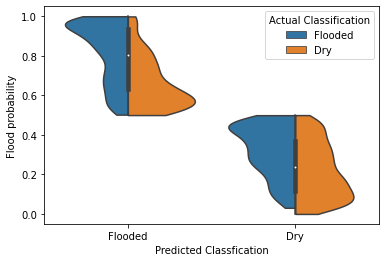

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.violinplot(data=flood_hazard.test.Y_, x="pred", y="prob", hue="inundated",order=[  "Flooded", "Dry",], cut=0,split=True)
ax.set(xlabel='Predicted Classfication', ylabel='Flood probability')
# ax.invert_xaxis()
plt.legend(title='Actual Classification', loc='upper right', )

plt.show()

Round times

In [29]:
allHours = []
for hour in hours:
    now = hour
    newNow = (hour_rounder(now))
    allHours.append(newNow)
(allHours)

[datetime.datetime(2015, 5, 12, 9, 0),
 datetime.datetime(2015, 5, 12, 16, 0),
 datetime.datetime(2015, 5, 13, 12, 0),
 datetime.datetime(2015, 5, 13, 12, 0),
 datetime.datetime(2015, 5, 13, 12, 0),
 datetime.datetime(2015, 5, 13, 12, 0),
 datetime.datetime(2015, 5, 13, 13, 0),
 datetime.datetime(2015, 5, 13, 13, 0),
 datetime.datetime(2015, 5, 13, 14, 0),
 datetime.datetime(2015, 5, 14, 10, 0),
 datetime.datetime(2015, 5, 14, 11, 0),
 datetime.datetime(2015, 5, 15, 8, 0),
 datetime.datetime(2015, 5, 15, 9, 0),
 datetime.datetime(2015, 5, 15, 18, 0),
 datetime.datetime(2015, 5, 16, 13, 0),
 datetime.datetime(2015, 5, 17, 8, 0),
 datetime.datetime(2015, 5, 17, 8, 0),
 datetime.datetime(2015, 5, 17, 8, 0),
 datetime.datetime(2015, 5, 17, 8, 0),
 datetime.datetime(2015, 5, 17, 8, 0),
 datetime.datetime(2015, 5, 17, 9, 0),
 datetime.datetime(2015, 5, 17, 10, 0),
 datetime.datetime(2015, 5, 17, 10, 0),
 datetime.datetime(2015, 5, 17, 10, 0),
 datetime.datetime(2015, 5, 17, 11, 0),
 datetime

Create reprojected tif files

In [26]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
! pwd
rain =[]
for date in allHours:
    day =date.day
    month = date.month
    if month < 10:
        month=f"0{date.month}"
    hour=date.hour
    year = date.year
    if int(hour) <10 : hour = f"0{hour}"
    if int(day) <10 : day = f"0{day}"
    

     
    
    f =r"Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_{}{}{}-{}0000.grib2-8bit-8bit.tif".format(year,month, day, hour)
    print(f)
    with rasterio.open(f) as src:
#             src = rasterio.open(file, driver="AAIGrid" ).read(1)
        dst_crs=5070

        transform, width, height = calculate_default_transform(
        src.crs, "EPSG:5070", src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
        with rasterio.open('Exported_Tif_Files/reproject/GaugeCorr_QPE_01H_00.00_{}{}{}-{}0000.grib2-8bit-8bit.tif'.format(year,month, day, hour), 'w', **kwargs) as dst:
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs="EPSG:5070",
                    resampling=Resampling.nearest)
        

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ianwmcintoshlinux2/code/Users/ianwmcintosh/311-Publish
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150512-090000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150512-160000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150513-120000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150513-120000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150513-120000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150513-120000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150513-130000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150513-130000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150513-140000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150514-100000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr_QPE_01H_00.00_20150514-110000.grib2-8bit-8bit.tif
Exported_Tif_Files/GaugeCorr

Currently the hazard estimates isn't designed to handle daily variables. We'll need to add those afterwards. 

## Make the tif into a vrt with one file. 

For each date that has a sample
* select subset of dataframe
* use samping from rasterio to collect data. 

Reset the index of both training dataframes

In [30]:
flood_hazard.train.X_ = flood_hazard.train.X_.reset_index()
flood_hazard.train.Y_ = flood_hazard.train.Y_.reset_index()

Drop duplicates in the Y training set

In [31]:
duplicates = flood_hazard.train.X_.duplicated(subset=['date', 'X', 'Y'])
flood_hazard.train.X_['duplicated'] = duplicates
indices = flood_hazard.train.X_.index[flood_hazard.train.X_['duplicated'] == True].tolist()
flood_hazard.train.Y_ = flood_hazard.train.Y_.drop(indices)
len(flood_hazard.train.Y_)

4963

Drop duplicates in the X training set

In [32]:
flood_hazard.train.X_ = flood_hazard.train.X_.drop_duplicates(subset=['date', 'X', 'Y'])
dates = flood_hazard.train.X_['date']
rounded = []
for date in dates:
    rounded.append(hour_rounder(date))
flood_hazard.train.X_['date'] = rounded
flood_hazard.train.X_

,index,X,Y,Flooded/Dry,year_of_loss,date,dem,hand,Distance2Streams,FlowAccumulation,AverageKSAT,impervious,duplicated
0,284,-162001.972,812124.971,1,2017,2017-03-09 15:00:00,223.828,9.396,343.106,1.000,0.001,60,False
1,910,-166689.182,807018.976,1,2015,2015-06-24 15:00:00,199.523,3.809,144.947,1.000,0.001,56,False
2,911,-146909.129,820063.194,1,2015,2015-06-22 12:00:00,185.972,21.413,635.195,1.000,0.001,11,False
3,912,-169492.752,813702.365,1,2015,2015-06-27 23:00:00,201.582,15.862,121.977,1.000,0.001,85,False
4,913,-163395.438,801947.726,1,2015,2015-06-18 12:00:00,167.153,23.284,663.023,2.000,0.001,60,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5003,4470220,-168808.502,814342.762,0,2016,2016-02-26 16:00:00,251.785,59.711,408.029,1.000,0.001,62,False
5004,5521960,-177036.530,791112.083,0,2015,2015-05-25 16:00:00,232.808,31.547,1574.243,1.000,0.000,84,False
5005,4383204,-169871.227,816162.530,0,2018,2015-05-25 18:00:00,259.068,36.417,150.590,1.000,0.001,29,False
5006,3568162,-173339.311,795304.591,0,2016,2017-01-13 08:00:00,208.631,13.940,349.415,1.000,0.000,34,False


Drop index column in both

In [33]:
flood_hazard.train.Y_ = flood_hazard.train.Y_.drop(columns=['index'])
flood_hazard.train.X_ = flood_hazard.train.X_.drop(columns=['index'])

Set Up Model Using Reprojected Tif Files

In [34]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
flood_hazard.train.X_['Precipitation']= 0
flood_hazard.test.X_['Precipitation']= 0
for date in flood_hazard.train.X_['date'].unique():
    print(date)
    newDate = pd.Timestamp(date)
    # row = flood_hazard.train.X_.loc[flood_hazard.train.X_['date']== newDate]
    # x,y = row.X, row.Y
    xy= flood_hazard.train.X_.loc[flood_hazard.train.X_['date']==date].apply(lambda row: (row.X, row.Y),axis=1).values
    day = newDate.day
    month = newDate.month
    if month < 10:
        month=f"0{newDate.month}"
    hour=newDate.hour
    year = newDate.year
    if int(hour) <10 : hour = f"0{hour}"
    if int(day) <10 : day = f"0{day}"
    with rasterio.open('Exported_Tif_Files/reproject/GaugeCorr_QPE_01H_00.00_{}{}{}-{}0000.grib2-8bit-8bit.tif'.format(year,month, day, hour)) as src:
        high_risk=[val[0] for val in src.sample(xy) ]
    flood_hazard.train.X_.loc[flood_hazard.train.X_['date']==date, 'Precipitation']=high_risk

2017-03-09T15:00:00.000000000
2015-06-24T15:00:00.000000000
2015-06-22T12:00:00.000000000
2015-06-27T23:00:00.000000000
2015-06-18T12:00:00.000000000
2015-06-22T09:00:00.000000000
2015-07-30T18:00:00.000000000
2015-07-27T08:00:00.000000000
2015-06-24T10:00:00.000000000
2015-06-25T13:00:00.000000000
2015-07-29T09:00:00.000000000
2015-06-23T11:00:00.000000000
2015-07-31T14:00:00.000000000
2015-07-24T09:00:00.000000000
2015-06-19T14:00:00.000000000
2015-07-19T15:00:00.000000000
2015-06-05T12:00:00.000000000
2015-06-21T18:00:00.000000000
2015-07-16T17:00:00.000000000
2015-07-21T13:00:00.000000000
2015-06-17T10:00:00.000000000
2015-06-18T18:00:00.000000000
2015-06-08T13:00:00.000000000
2015-08-29T09:00:00.000000000
2015-07-29T16:00:00.000000000
2015-07-08T10:00:00.000000000
2015-05-29T12:00:00.000000000
2015-06-17T16:00:00.000000000
2015-06-19T16:00:00.000000000
2015-07-19T18:00:00.000000000
2015-07-20T11:00:00.000000000
2015-07-29T08:00:00.000000000
2015-07-06T09:00:00.000000000
2015-06-18

## Run Model

Final Results of Model

In [35]:
#flood_hazard.drop_duplicates()
flood_hazard.XColumns.append("Precipitation")
flood_hazard.set_up_categorical()

Random Forest tests for 
rf Confusion Matrix
 
Predicted   Dry  Flooded
Actual                  
Dry        1025      272
Flooded     365      933
rf accuracy: 0.755
AUC= 0.8405155669180865


Save Model

In [36]:
flood_hazard.save_model("311.rf")